In [1]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report, confusion_matrix  
# from sklearnex import patch_sklearn 

# patch_sklearn()

# Helper functions

In [3]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

# Loading data

In [4]:
matches = pd.read_csv("Matches/Bas3.csv", index_col=0)
# dist_folder = "Distances_jw"
dist_folder = "Distances_levenshtein"

In [5]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

In [6]:
len(matches[matches['transaction_indx'] != 'None']["permission_indx"].unique())

40

In [7]:
matches[matches['transaction_indx'] != 'None']

,Annotator,transaction_indx,permission_indx
30,Bas,4097,32
31,Bas,4242,33
32,Bas,4242,33
33,Bas,4228,34
37,Bas,4220,38
39,Bas,4202,40
40,Bas,4202,40
42,Bas,4217,42
43,Bas,4182,43
44,Bas,4219,44


In [8]:
X = distances[distances['permission_indx'].isin(matches["permission_indx"].unique())]
X["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        X.loc[indx, "Match"] = 1
data = X.to_numpy().astype("float")[:, 2:-1]
y = X.to_numpy().astype("float")[:, -1]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

<ipython-input-8-b5019eb2ad95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Match"] = 0
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# Normalizing data

# Oversampling

In [9]:
# ros = RandomOverSampler()
# ros = SMOTE()
# X_train, y_train = ros.fit_resample(X_train, y_train)

# Rule based

# If >3 match

In [10]:
pred = []
for x in X_test:
    if (x == 1.).sum() >= 4:
        pred.append(1)
    else:
        pred.append(0)

In [11]:
print("recall score: ", recall_score(y_test, pred))
print("precision score: ", precision_score(y_test, pred))
print("f1 score: ", f1_score(y_test, pred))

recall score:  0.625
precision score:  0.059880239520958084
f1 score:  0.10928961748633881


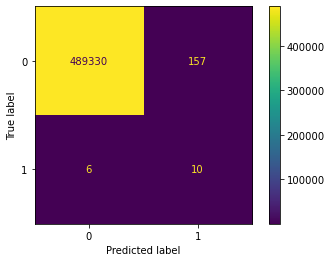

In [12]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# If >3 cells match for >0.8

In [13]:
pred = []
for x in X_test:
    if (x > 0.7).sum() >= 6:
        pred.append(1)
    else:
        pred.append(0)

In [14]:
print("recall score: ", recall_score(y_test, pred))
print("precision score: ", precision_score(y_test, pred))
print("f1 score: ", f1_score(y_test, pred))

recall score:  0.75
precision score:  0.08450704225352113
f1 score:  0.1518987341772152


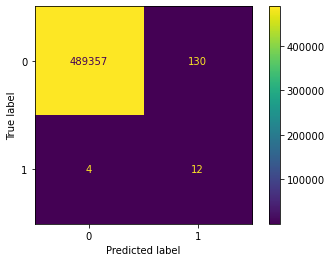

In [15]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# All 0

In [16]:
pred = np.zeros(len(y_test))
pred

array([0., 0., 0., ..., 0., 0., 0.])

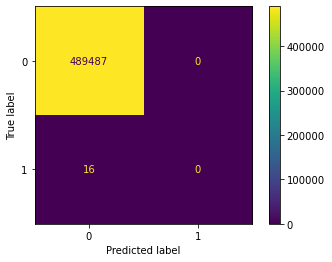

In [17]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# K nearest neighbors

In [18]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)

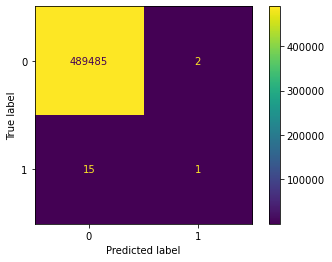

In [19]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [20]:
print("recall score: ", recall_score(y_test, pred))
print("precision score: ", precision_score(y_test, pred))
print("f1 score: ", f1_score(y_test, pred))

recall score:  0.0625
precision score:  0.3333333333333333
f1 score:  0.10526315789473684


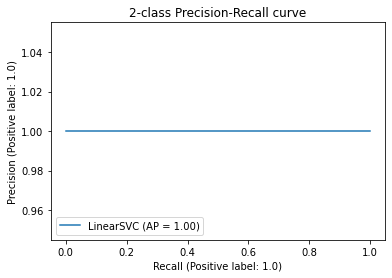

In [21]:
display = PrecisionRecallDisplay.from_estimator(
    neigh, X_train, y_train, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Logistic regression

In [107]:
from sklearn.linear_model import LogisticRegression

In [108]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)

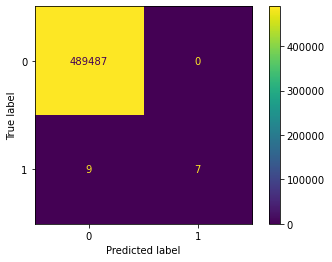

In [109]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [110]:
print("recall score: ", recall_score(y_test, pred))
print("precision score: ", precision_score(y_test, pred))
print("f1 score: ", f1_score(y_test, pred))

recall score:  0.4375
precision score:  1.0
f1 score:  0.6086956521739131


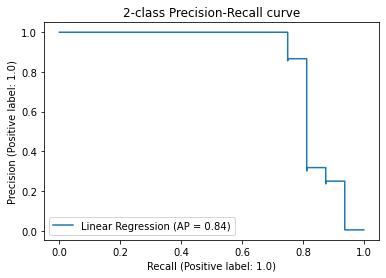

In [111]:
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="Linear Regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Naive Bayes

In [112]:
from sklearn.naive_bayes import MultinomialNB

In [113]:
clf = MultinomialNB().fit(X_train, y_train)
pred = clf.predict(X_test)

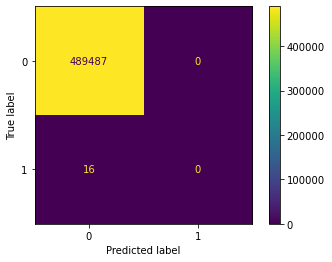

In [114]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [115]:
print("recall score: ", recall_score(y_test, pred))
print("precision score: ", precision_score(y_test, pred))
print("f1 score: ", f1_score(y_test, pred))

recall score:  0.0
precision score:  0.0
f1 score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


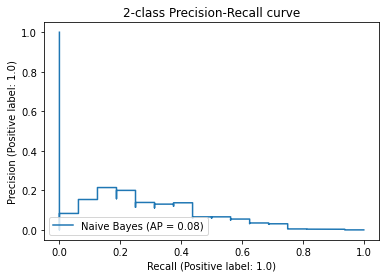

In [116]:
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="Naive Bayes"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# SVM

In [117]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [118]:
# from sklearn.linear_model import SGDClassifier
# clf = SGDClassifier()
# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)

In [119]:
# from sklearn.svm import LinearSVC
# clf = LinearSVC()
# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)

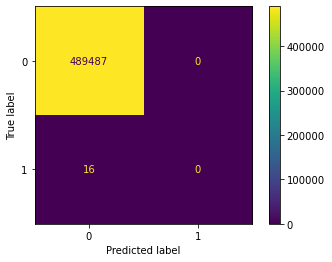

In [120]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [121]:
print("recall score: ", recall_score(y_test, pred))
print("precision score: ", precision_score(y_test, pred))
print("f1 score: ", f1_score(y_test, pred))

recall score:  0.0
precision score:  0.0
f1 score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


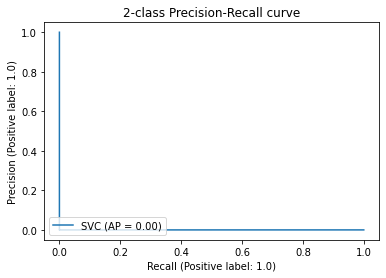

In [122]:
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="SVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Evaluating results

In [129]:
from sklearn.neural_network import MLPClassifier

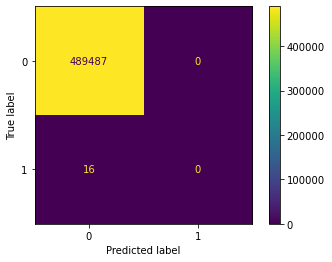

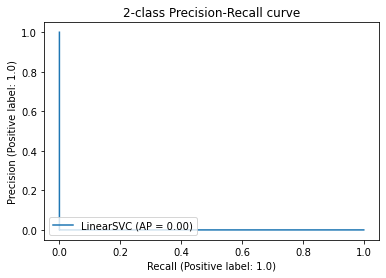

In [130]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

display = PrecisionRecallDisplay.from_estimator(
    clf, X_train, y_train, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [95]:
import tensorflow as tf
from tensorflow import keras

In [96]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(X_train.shape[-1]),
    tf.keras.layers.Dense(32, activation='softmax'),
    tf.keras.layers.Dense(16, activation='softmax'),
    tf.keras.layers.Dense(1, activation='softmax'),
])

In [103]:
model.compile("adam", loss='binary_crossentropy', metrics=["Accuracy"])

In [104]:
model.fit(X_train, y_train, batch_size = 128)

8924/8924 [==============================] - 60s 7ms/step - loss: 2.8180e-04 - Accuracy: 2.3639e-05


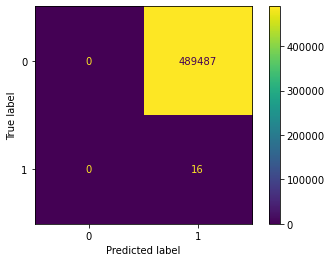

In [106]:
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()